This code is about the simulation of the fluid mushroom equation and it's wave speed.

Importing useful libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import matplotlib.animation as animation
from IPython.display import HTML
from scipy import stats
import time
start_time = time.time()
%matplotlib inline
import multiprocessing 

This is the main resolution code

In [2]:
#Debut du calcul

def solve(verbose=True):
    
    def primal(mu,impx):
        eps = 1e-7
        u = np.zeros(Nx)
        tarray = (mu>eps)
        u[tarray]= impx[tarray]/mu[tarray]
        mu[np.logical_not(tarray)] = 0
        impx = u*mu
        return mu,u,impx

    def fnum_x(h,mu,impx):
        #Remise dans les variables primales
        mu,u,impx = primal(mu,impx)
        fmu = np.zeros(Nx)
        fimpx = np.zeros(Nx)
        #Initialisation aux variables centrees
        mug = np.roll(mu,1)
        impxg = np.roll(impx,1)
        ug = np.roll(u,1)
        #Moyenne de Roe
        uc = np.zeros(Nx)
        tarray = (np.sqrt(mu)+np.sqrt(mug)>0)
        uc[tarray] = (np.sqrt(mu[tarray])*u[tarray]+np.sqrt(mug[tarray])*ug[tarray])/ \
            (np.sqrt(mu[tarray])+np.sqrt(mug[tarray]))
        #Calcul des valeurs propres
        l1 = uc + sqrtTemp*np.ones(Nx)
        l2 = uc - sqrtTemp*np.ones(Nx)
        #Decentrement amont pour chacun des invariants de Riemann
        #Wave strengths
        r1 = (-(mu-mug)*l2+(impx-impxg))/(2*sqrtTemp)
        r2 = ((mu-mug)*l1-(impx-impxg))/(2*sqrtTemp)
        r1 = np.abs(l1)*r1
        r2 = np.abs(l2)*r2
        #Calcul des flux
        fmu = 0.5*(impx+impxg - (r1+r2))
        fimpx = 0.5*(impx*u+Temp*mu+impxg*ug+Temp*mug - (r1*l1 + r2*l2))
        return fmu, fimpx

    def solve_adv_x(h,mu,impx):
        fmu, fimpx = fnum_x(h,mu,impx)
        #Mise a jour des valeurs
        mu += h/dx*(fmu-np.roll(fmu,-1))
        impx += h/dx*(fimpx-np.roll(fimpx,-1))
        mu,u,impx = primal(mu,impx)
        return mu,impx,u
    
    def find_first(test):
        try:
            ans = np.min(X[test])
        except:
            ans = Nx+1

        return ans

    def coeffs_P3():
        a = (lbda+f0)
        b = (f0**2+lbda*f0 -f0*F0)
        c = -F0*f0*(lbda+2*f0)
        d = (F0*f0)**2
        return [a,b,c,d]

    def coeffs_Q():
        a,b,c,d = coeffs_P3()
        return [a, 2*b, 3*c, 4*d]
    
    def vitesse_theorique(sign=-1):
        y = np.min( np.roots(coeffs_Q()))
        p3_y = np.polyval(coeffs_P3(),y)
        s_sel = sign*np.sqrt(-Temp*(y**4)/p3_y)
        return s_sel


    #Initialisation 
    dx = Lx/(Nx-1)
    def f(c):
        return c
    R = Lx/40
    
    X = np.linspace(0,Lx,Nx)
    mu0 = np.zeros(Nx)
    mu0[np.abs(X-Lx/2)<R]=0.01
    u0 = np.zeros(Nx)
    rho0 = np.zeros(Nx)
    C0 = np.full((Nx),f0)

    def F(*args):
        return F0
    
    mu = mu0
    u  = u0
    rho = rho0
    C  = C0
    
    Mu_mem= [mu]
    U_mem = [u]
    Rho_mem = [rho0]
    C_mem = [C]
    T_mem = [0]
    Times=[]

    #Variables conservatives
    impx = mu*u
    #Boucle en temps
    t_print = 0
    n_print = 0
    t = 0
    n = 0
    Firsts =[]
    while t<T:
        #On détermine le pas de temps
        dt_adv = cfl*dx/(np.max(np.abs(u))+sqrtTemp)
        dt = dt_adv
        #dt = h
        t += dt
        t = min(T,t)
        n+=1

        #Résolution de l'advection par splitting de Strang (en variables conservatives)
        mu,impx,u=solve_adv_x(dt,mu,impx)
        #Termes de réaction
        dxC = (C-np.roll(C,1))/(2*dx)
        #Termes de réaction
        #Resolution implicite de mu, impx, impy et rho (C fixé)
        a = dt**2*F(np.abs(u),Temp)
        b = 1 - dt*f(C) - dt**2*f(C)*F(np.abs(u),Temp) + dt*rho
        c = -mu - dt*f(C)*rho
        mu = (-b+np.sqrt(b**2-4*a*c))/(2*a)
        rho = rho+ dt*F(np.abs(u),Temp)*mu
        impx = (impx+dt*mu*dxC)/(1+dt*lbda+dt*rho)
        #Resolution implicite de C
        C = C/(1+dt*B*rho*C) 
        
        
        first=find_first(rho>1)
        Firsts+=[first]
        Times += [t]
        
        if  t > T*n_print/Nprint:
            Mu_mem +=[mu]
            Rho_mem +=[rho]
            C_mem +=[C]
            T_mem+=[t]
            n_print +=1
            if (n_print % 200 == 0) and verbose:
                print('n=',n, 't=',t, 'dt=',dt, 'n_print=', n_print)
    

    front_start = len(Times)//2

    xfit = np.array(Times[front_start:])
    yfit = np.array(Firsts[front_start:])
    filt = (yfit > 50)
    
    xfit = xfit[filt]
    yfit = yfit[filt]
    
    s_simu, intercept, r_value, p_value, std_err = stats.linregress(xfit,yfit)
    s_sel=vitesse_theorique(sign=-1)
    
    return Mu_mem, Rho_mem, C_mem, T_mem, s_simu, s_sel
    


Example of a simulation

n= 363 t= 19.92234545154773 dt= 0.051864318389488615 n_print= 200
n= 723 t= 39.90253239002768 dt= 0.05764779992447436 n_print= 400
n= 1085 t= 59.931183369262214 dt= 0.06148036373700057 n_print= 600
n= 1448 t= 79.93557137143053 dt= 0.050644254641709754 n_print= 800
n= 1811 t= 99.94254701194649 dt= 0.057587589277837845 n_print= 1000


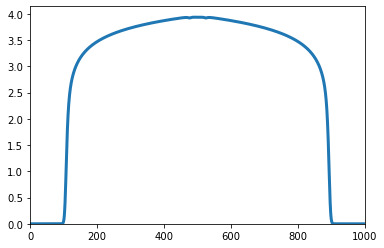

In [13]:
#Numerical Parameters
Nx = 2000
Lx = 1000 
T = 100
cfl = 1

#Physical Parameters
lbda = 3
Temp = 10
sqrtTemp = np.sqrt(Temp)
B = .7
F0 = .8
f0 = 1

#Number of outputs 
Nprint = 1000

Mu_mem, Rho_mem, C_mem, T_mem, s_simu, s_sel = solve()
X = np.linspace(0,Lx,Nx)
fig = plt.figure()
ax = plt.axes(xlim=(0, Lx), ylim=(0, Rho_mem[-1][Nx//2]+.2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(X,Rho_mem[20*i][:])
    return line,

ani = animation.FuncAnimation(fig, animate,init_func=init,frames= len(Mu_mem)//20, interval=50, blit=True)

from IPython.display import HTML
HTML(ani.to_jshtml())

Plotting the characteristic polynomial root's dependence with the wave speed s. 

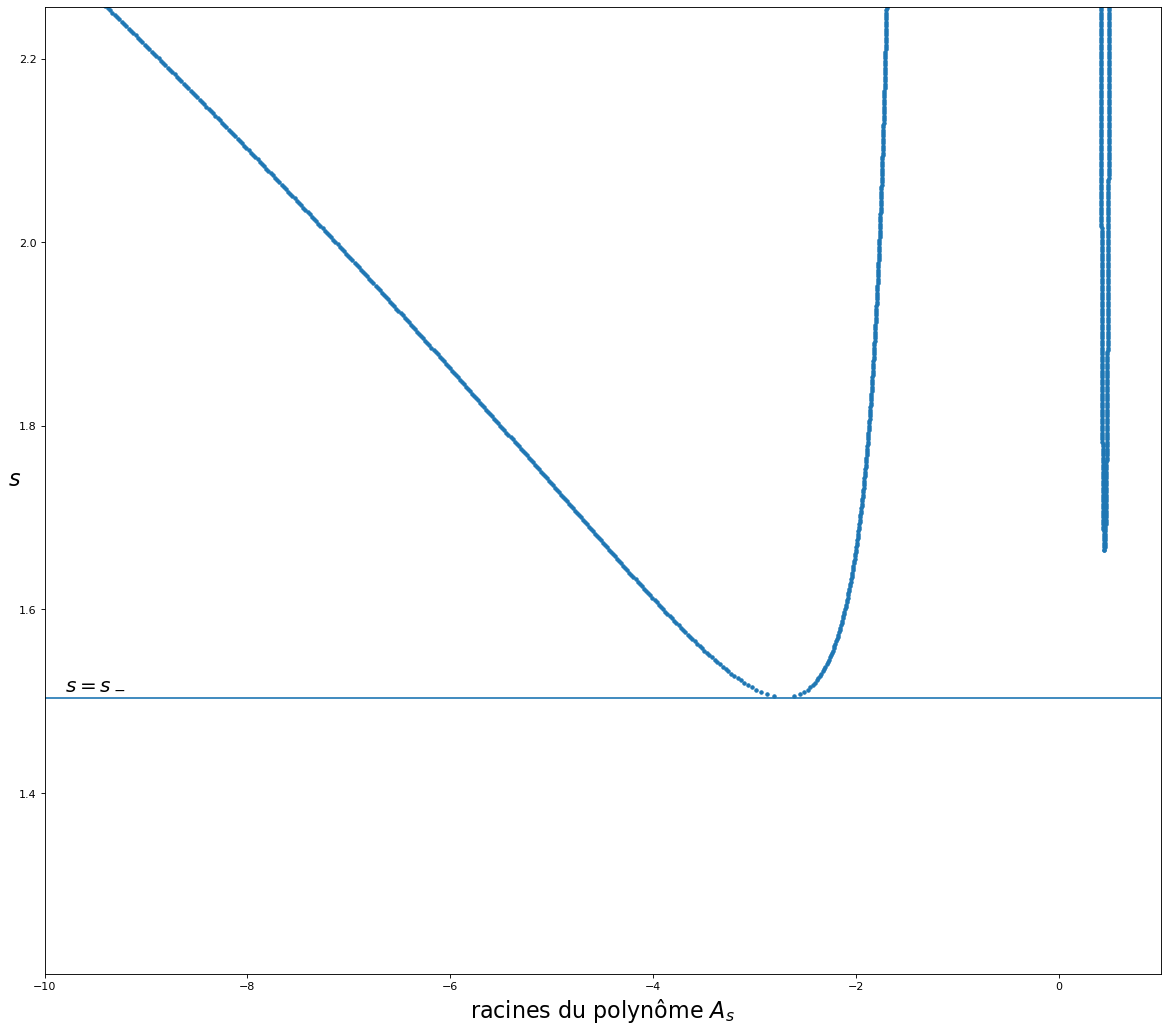

In [38]:
#Numerical Parameters
Nx = 2000
Lx = 1000 
T = 100
cfl = 1

#Physical Parameters
lbda = 1
Temp = 1
sqrtTemp = np.sqrt(Temp)
B = .7
F0 = .8
f0 = 1

#Number of outputs 
Nprint = 1000

def coeffs_P3():
    a = (lbda+f0)
    b = (f0**2+lbda*f0 -f0*F0)
    c = -F0*f0*(lbda+2*f0)
    d = (F0*f0)**2
    return [a,b,c,d]

def coeffs_Q():
    a,b,c,d = coeffs_P3()
    return [a, 2*b, 3*c, 4*d]

def vitesse_theorique(sign=-1):
    y = np.min( np.roots(coeffs_Q()))
    p3_y = np.polyval(coeffs_P3(),y)
    s_sel = sign*np.sqrt(-Temp*(y**4)/p3_y)
    return s_sel


def plot_roots():
    X =[]
    for n in np.linspace(0,50,10000):
        s = n/2
        roots = np.roots([1]+[s**2*x/Temp for x in coeffs_P3()])
        roots = roots[np.isreal(roots)]
        for i in range(len(roots)):
            X+=[[s,roots[i]]]

    fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    S = []
    Root = []
    for i in range(len(X)):
        S += [X[i][0]]
        Root += [X[i][1]]
    plt.figsize=(1,1)
    plt.axis((-10,1,.8*vitesse_theorique(sign=1),1.5*vitesse_theorique(sign=1)))
    plt.scatter(Root,S, marker='.')
    plt.axhline(y=vitesse_theorique(sign=1))
    plt.ylabel('$s$',fontsize=20,rotation=0)
    plt.text(-9.8,vitesse_theorique(sign=1)+.01,'$s=s_-$',rotation=0,fontsize=18)

    plt.xlabel('racines du polynôme $A_s$',fontsize=20)

    
plot_roots()

This plots the convergence of the simulation wave speed and shows its order is 1

In [5]:
#Etude ordre de convergence de la vitesse du schema 
Lx = 1000

cfl = .9
T = 100
Nprint = 1000


lbda = 3
Temp = 10
sqrtTemp = np.sqrt(Temp)
B = .7
F0 = .8
f0 = 1

S_simu =[]
H=[]
for i in range(10):
        step_time= time.time()
        Nx = 2000+800*i
        Mu_mem, Rho_mem, C_mem, T_mem, s_simu, s_sel = solve(verbose=False)
        step_time = time.time() - step_time
        print('step i =',i,'(Nx=', Nx, '), done in ', step_time, 'seconds')
        H += [Nx]
        S_simu += [s_simu]
 

step i = 0 (Nx= 2000 ), done in  0.9095654487609863 seconds
step i = 1 (Nx= 2800 ), done in  1.4531807899475098 seconds
step i = 2 (Nx= 3600 ), done in  2.2570607662200928 seconds
step i = 3 (Nx= 4400 ), done in  2.823902130126953 seconds
step i = 4 (Nx= 5200 ), done in  3.5215744972229004 seconds
step i = 5 (Nx= 6000 ), done in  4.4417009353637695 seconds
step i = 6 (Nx= 6800 ), done in  5.987538814544678 seconds
step i = 7 (Nx= 7600 ), done in  7.072909355163574 seconds
step i = 8 (Nx= 8400 ), done in  8.677523851394653 seconds
step i = 9 (Nx= 9200 ), done in  11.946256399154663 seconds


ordre= -0.7456731884460034


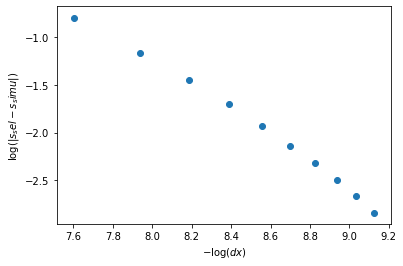

In [6]:
log_error = np.log(np.abs((S_simu-s_sel)))
log_dx = [np.log(x) for x in H ]

plt.scatter(log_dx,log_error)
plt.ylabel('$\log(|s_sel-s_simu|)$')
plt.xlabel('$-\log(dx)$')

ordre, intercept, r_value, p_value, std_err = stats.linregress([np.log(s_sel-x) for x in S_simu],[np.log(x) for x in H ])
print('ordre=', ordre)

This shows the simulation wave speed is close to the mathematical selected wave speed for multiple physical parameters.
Smaller dx = Lx/(Nx-1) means better precision but slower calculation.

done for i = 0 j= 0
done for i = 0 j= 1
done for i = 0 j= 2
done for i = 0 j= 3
done for i = 0 j= 4
done for i = 1 j= 0
done for i = 1 j= 1
done for i = 1 j= 2
done for i = 1 j= 3
done for i = 1 j= 4
done for i = 2 j= 0
done for i = 2 j= 1
done for i = 2 j= 2
done for i = 2 j= 3
done for i = 2 j= 4
done for i = 3 j= 0
done for i = 3 j= 1
done for i = 3 j= 2
done for i = 3 j= 3
done for i = 3 j= 4
done for i = 4 j= 0
done for i = 4 j= 1
done for i = 4 j= 2
done for i = 4 j= 3
done for i = 4 j= 4
done for i = 5 j= 0
done for i = 5 j= 1
done for i = 5 j= 2
done for i = 5 j= 3
done for i = 5 j= 4
done for i = 6 j= 0
done for i = 6 j= 1
done for i = 6 j= 2
done for i = 6 j= 3
done for i = 6 j= 4
done for i = 7 j= 0
done for i = 7 j= 1
done for i = 7 j= 2
done for i = 7 j= 3
done for i = 7 j= 4
done for i = 8 j= 0
done for i = 8 j= 1
done for i = 8 j= 2
done for i = 8 j= 3
done for i = 8 j= 4
done for i = 9 j= 0
done for i = 9 j= 1
done for i = 9 j= 2
done for i = 9 j= 3
done for i = 9 j= 4


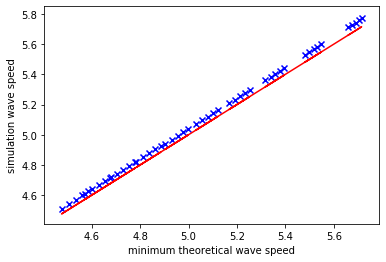

In [8]:
Nx = 10000
Lx = 1000
cfl = .9
T = 100
Nprint = 1000

B = .5
f0 = 1
Temp = 10
sqrtTemp = np.sqrt(Temp)

S_simu =[]
S_sel = []
for i in range(10):
    for j in range(5):
        lbda = .3+.1*i
        F0 = .5+.1*j

        Mu_mem, Rho_mem, C_mem, T_mem, s_simu, s_sel = solve(verbose=False)
        print('done for i =',i, 'j=',j)
        S_simu += [s_simu]
        S_sel += [s_sel]


fig = plt.figure()
plt.scatter([-x for x in S_sel],[-x for x in S_simu], marker='x', c='b')
plt.ylabel('simulation wave speed')
plt.xlabel('minimum theoretical wave speed')
plt.plot([-x for x in S_sel],[-x for x in S_sel], c='r')
plt.show()